# Import AFEP_parse and dependencies
AFEP_parse.py contains all the functions and library calls necessary to run the notebook

# Required modules:
- numpy
- pandas
- matplotlib
- alchemlyb (`pip install git+https://github.com/alchemistry/alchemlyb`)
- natsort (for sorting file names)
- glob (for unix-like file paths)

In [1]:
from AFEP_parse import *
from alchemlyb.preprocessing import subsampling

# User parameters

In [2]:
#path='/home/ezry/winHome/Documents/ELIC_Data/PCPGPE211/Se'
path='/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/POCE_9/'
filename='PO*.fepout'

temperature = 303.15

## IMPORTANT: Make sure the temperature above matches the temperature used to run the simulations.

In [3]:
plt.rcParams['figure.dpi'] = 150
import os

RT = 0.00198720650096 * temperature
#path='/path/to/output/files'
filename='PO*.fepout'
fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 44 fepout files.
Total size:0.04GB


In [4]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = True
detectEQ = False
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

# Small data sets can be read and decorrelated sequentially, if desired
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [5]:
if totalSize < maxSize:
    u_nk, affix = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ)
    
else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}.\nTry the read, decorrelate, save method in the Expanded version of this notebook or increase the maxSize variable above.\nIn the future, consider using less frequent sampling (e.g. every 100 steps).")

Decorrelating samples. Flag='True'


/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time', name='').duplicated('time').any()


# Carry out MBAR Fitting and Analyses

In [6]:
u_nk = u_nk.sort_index(level=1)

In [7]:
counts = pd.DataFrame()
for fl in set(u_nk.index.get_level_values(1)):
    counts[fl] = u_nk.loc[(slice(None), fl), :].count()

In [8]:
from scipy.signal import correlate
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit, leastsq

In [9]:
def getCorr(ser, timeStep):
    flucs = ser - np.mean(ser)
    valsRaw = correlate(flucs, flucs, mode='same')
    steps = ser.index.get_level_values(0)
    dt = [0]
    dt = np.concatenate(([0], (np.cumsum(steps[1:]-steps[:-1]))))*timeStep
    idx = dt[:len(valsRaw)//2]

    
    try:
        valsSplit = valsRaw[len(valsRaw)//2:-1]
        corr = pd.Series(valsSplit, index=idx)
    except:
        valsSplit = valsRaw[len(valsRaw)//2:]
        corr = pd.Series(valsSplit, index=idx)
    return corr/np.max(corr)

def my_exp(t, K):
    return np.exp(-K * t)

In [15]:
#Calculate decay times in ps
groups = u_nk.groupby('fep-lambda')
decayTimes = pd.DataFrame()
sampling = pd.DataFrame()
for key, group in groups:
    trimmed = group.dropna(axis=1)
    for col in trimmed:
        if col != key:
            ser = trimmed[col]
            corr = getCorr(ser, timeStep=0.002)
            [K], _ = sp.optimize.curve_fit(my_exp, corr.index, corr.values, maxfev=1000)
            decayTimes.loc[key, col] = 1/K
            sampling.loc[key, col] = corr.index[1]-corr.index[0]
sampling = sampling.sort_index(axis=0).sort_index(axis=1).copy()
decayTimes = decayTimes.sort_index(axis=0).sort_index(axis=1).copy()

/tmp/ipykernel_1999511/4187185378.py:19: RuntimeWarning: overflow encountered in exp
  return np.exp(-K * t)


In [16]:
fwdDecay = pd.Series(np.diagonal(decayTimes, offset=1), index=decayTimes.index[:-1])
bwdDecay = pd.Series(np.diagonal(decayTimes, offset=-1), index=decayTimes.index[1:])
fwdSmpl = pd.Series(np.diagonal(sampling, offset=1), index=sampling.index[:-1])
bwdSmpl = pd.Series(np.diagonal(sampling, offset=-1), index=sampling.index[1:])

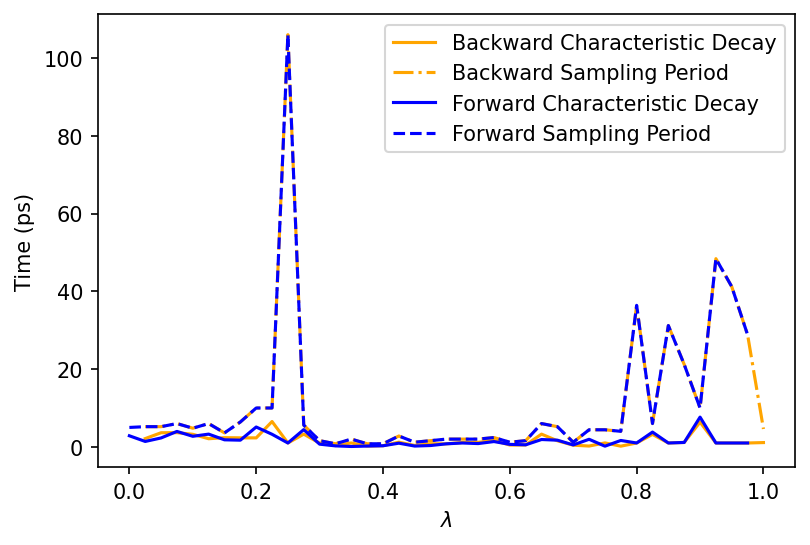

In [26]:
plt.plot(bwdDecay, label='Backward Characteristic Decay', color='orange')
plt.plot(bwdSmpl, label='Backward Sampling Period', linestyle='-.', color='orange')
plt.plot(fwdDecay, label='Forward Characteristic Decay', color='blue')
plt.plot(fwdSmpl, label='Forward Sampling Period', linestyle='--', color='blue' )

plt.ylabel('Time (ps)')
plt.xlabel(r'$\lambda$')
plt.legend()
#plt.savefig(f'

In [ ]:
bar = BAR()
bar.fit(u_nk)

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to conver to units of kcal/mol.

In [ ]:
l, l_mid, f, df, ddf, errors = get_BAR(bar)
changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1], 3)} kcal/mol'
print(changeAndError)

# Plot the change in free energy based on MBAR estimates

In [ ]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}\n{changeAndError}')
plt.savefig(f'{path}dG_cumulative_kT_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
"""
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.savefig(f'{path}dG_cumulative_kcal_per_mol_{affix}.png', dpi=600)
plt.show()
"""
# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

# Per-window change in kT

plt.errorbar(l[1:-1], np.diff(df), marker='.')
plt.xlabel('lambda (L)')
plt.ylabel("dG'(L)")
plt.title(f'derivative of dG {affix}')
plt.savefig(f'{path}dG_prime_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [ ]:
convergence_plot(u_nk, l)
plt.title(f'Convergence {affix}')
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [ ]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

In [ ]:
hyst = dG_f + np.array(dG_b)
plt.vlines(l_mid, np.zeros(len(l_mid)), hyst*RT, label="fwd - bwd", linewidth=2)
plt.ylim(-1,1)
plt.plot(l_mid, hyst*RT, linewidth=1)
plt.ylim(-1,1)
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G (kcal/mol)')
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)

# OPTIONAL: Estimate and plot the Cumulative Density function (CDF) for the differences shown above.

In [ ]:
from scipy.special import erfc
from scipy.optimize import curve_fit as scipyFit
from scipy.stats import skew
#Wrapper for fitting the normal CDF
def cumFn(x, m, s):
    r = norm.cdf(x, m, s)
    return r

def pdfFn(x,m,s):
    r = norm.pdf(x,m,s)
    return r

In [ ]:
diff = dG_f + np.array(dG_b)
diff.sort()
X = diff*RT
Y = np.arange(len(X))/len(X)

#fit a normal distribution to the existing data
#fitted = norm.fit(X)

In [ ]:
#fit a normal distribution to the existing data

if DiscrepancyFitting == 'LS':
    fitted = scipyFit(cumFn, X, Y)[0] #Fit norm.cdf to (X,Y)
elif DiscrepancyFitting == 'ML':
    #fitted = scipyFit(pdfFn, X, Y)[0]
    fitted = norm.fit(X) # fit a normal distribution to X
else:
    raise("Error: Discrepancy fitting code not known. Acceptable values: ML or LS")
discrepancies = X

dx = 0.01
cdfXnorm  = np.arange(np.min(X), np.max(X), dx)
cdfYnorm = norm.cdf(cdfXnorm, fitted[0], fitted[1])
cdfYexpected = norm.cdf(X, fitted[0], fitted[1])

#plot the data as they are (estimate the CDF) and the fitted cdf
fig, (cdfAx, cdfResid, pdfAx, pdfResid) = plt.subplots(4, 1, sharex=True)
plt.xlabel('Difference in delta-G')

cdfAx.scatter(X, Y, 2, label="Fwd bkd differences")
cdfAx.plot(cdfXnorm, cdfYnorm, label="Normal Distribution", color="orange")
cdfAx.set_ylabel("CDF")
cdfAx.legend()

#cdf Residuals
cdfResiduals = Y-cdfYexpected
cdfResid.plot(X, cdfResiduals)
cdfResid.set_ylabel("CDF residuals")

#pdf
dx = 0.01
dx = 0.01

binNum = 20
window = binNum
pdfY, pdfX = np.histogram(discrepancies, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2

pdfXnorm  = np.arange(np.min(X), np.max(X), dx)
pdfYnorm = norm.pdf(pdfXnorm, fitted[0], fitted[1])

pdfYexpected = norm.pdf(pdfX, fitted[0], fitted[1])

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")
pdfAx.plot(pdfXnorm, pdfYnorm, label="Fitted Normal Distribution", color="orange")

#pdf residuals
pdfResiduals = pdfY-pdfYexpected
pdfResid.plot(pdfX, pdfResiduals)
pdfResid.set_ylabel("PDF residuals") 


fig.set_figheight(10)
if DiscrepancyFitting == 'LS':
    cdfAx.title.set_text(f"Least squares fitting of cdf(fwd-bkwd)\nSkewness: {np.round(skew(X),2)}\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
    plt.savefig(f"{path}LeastSquaresCDF{affix}.png", dpi=600)
elif DiscrepancyFitting == 'ML':
    cdfAx.title.set_text(f"Maximum likelihood fitting of fwd-bkwd\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
    plt.savefig(f"{path}MaximumLikelihood{affix}.png", dpi=600)

plt.show()

# OPTIONAL DIAGNOSTICS

# For looking at FEP data as a time series. Can be useful diagnostically.

In [ ]:
forwardMask = u_nk.copy()
offset = u_nk.columns[1] - u_nk.columns[0]

for col in forwardMask.columns:
    forwardMask[col].values[:] = 0

for x in set(u_nk.index.get_level_values(1)):
    forwardMask.loc[(slice(None),x),np.round(x+offset, 3)] = True

forwardMask = forwardMask.dropna(axis=1)

backwardMask = u_nk.copy()
offset = u_nk.columns[1] - u_nk.columns[0]

for col in backwardMask.columns:
    backwardMask[col].values[:] = 0

for x in set(u_nk.index.get_level_values(1)):
    backwardMask.loc[(slice(None),x),np.round(x+offset, 3)] = True

backwardMask = backwardMask.dropna(axis=1)

In [ ]:
u_nk.mask(forwardMask.astype(bool))

In [ ]:
l = np.round(0.025*11, 3)
l2 = np.round(0.025*12, 3)
forward = u_nk.loc[(slice(None), l), l2]
plt.plot(forward.index.get_level_values(0), forward, label="forward")
reverse = -1*u_nk.loc[(slice(None), l2), l]
plt.plot(reverse.index.get_level_values(0), reverse, label="reverse")
plt.legend()

In [ ]:
histF, edgesF = np.histogram(forward, density=True)
histR, edgesR = np.histogram(reverse, density=True)

plt.plot(np.mean([edgesF[1:], edgesF[:-1]], axis=0), histF, label ="forward")
plt.plot(np.mean([edgesR[1:], edgesR[:-1]], axis=0), histR, label="backward")
plt.legend()

In [ ]:

plt.plot(l_mid, dG_f)
plt.plot(l_mid, -dG_b)
plt.title(f"fwd and -bwd exponential estimations {affix}")
plt.xlabel("lambda")
plt.ylabel("dG")
plt.savefig(f"{path}exponentials.png", dpi=600)

In [ ]:
plt.plot(l_mid, np.cumsum(dG_f))
plt.plot(l_mid, -np.cumsum(dG_b))
plt.title(f"fwd and -bwd exponential estimations {affix}")
plt.xlabel("lambda")
plt.ylabel("dG")
plt.savefig(f"{path}exponentials_cumulative_{affix}.png", dpi=600)

In [ ]:
# Using the exponential estimator to estimate an error

In [ ]:
import scipy.stats

In [ ]:
errors = []
for i in np.arange(len(dG_f)):
    errors.append(scipy.stats.sem([dG_f[i], -dG_b[i]]))

In [ ]:
np.linalg.norm(errors, ord=2)

In [ ]:
total = 0
for x in errors:
    total += x**2
np.sqrt(total)

# Alternative measure of hysteresis: Two-sample Bootstrap for forward/backward samples

In [ ]:
def diffMeans(X1, X2):
    return np.mean(X2)-np.mean(X1)

In [ ]:
#x1 and x2 should be numpy list-like data series
#nReps: the number of bootstrapped samples to make
#measure: a function that takes two list-likes and returns a single metric
#H0: the value of the null hypothesis (e.g. 0)

def TwoSampleBS(x1, x2, nReps, measure, H0):
    bootstrapStats = np.zeros(nReps)
    n1 = len(x1)
    n2 = len(x2)
    for i in np.arange(len(bootstrapStats)):
        sampX1 = x1[np.random.randint(0,n1,n1)]
        sampX2 = x2[np.random.randint(0,n2,n2)]
        bootstrapStats[i] = measure(sampX1, sampX2)
        
    pvalue = np.sum(bootstrapStats < H0)/nReps
    if (pvalue>0.5):
        pvalue = 1-pvalue
        
    return bootstrapStats, pvalue

In [ ]:
series0 = u_nk.iloc[:,0].dropna()
series1 = u_nk.iloc[:,1].dropna()
series0 = series0[series0 != 0]
series0 = series0.loc[(slice(None),series0.index[0][1])]
series1 = series1[series1 != 0]
series1 = series1.loc[(slice(None),series1.index[0][1])]

In [ ]:
groups = u_nk.groupby('fep-lambda')
#fig, axes = plt.subplots(ncols=len(groups))
fig, axes = plt.subplots(1)
flierprops = dict(marker='.', markerfacecolor='green', markersize=3, linestyle=None, markeredgecolor='green')
i = -1
for key, group in groups:
    i=i+1
    ax = axes
    ax.boxplot(group[group!=0].dropna(axis=1).iloc[:,0], showfliers=False, flierprops=flierprops)
    #if i > 0:
        #ax.set_xticks([])
        #ax.set_yticks([])
        #ax.axis('off')
    try: 
        ax.boxplot(group[group!=0].dropna(axis=1).iloc[:,1], showfliers=False, flierprops=flierprops)
    except:
        continue
fig.tight_layout()

In [ ]:
plt.clf()
import seaborn as sns
groups = u_nk.groupby('fep-lambda')

for key, group in groups:
    sns.boxplot(x=group[group!=0].dropna(axis=1).iloc[:,0])



In [ ]:
group[group!=0].dropna(axis=1)

In [ ]:
nReps=1000

bootstrapStats, pvalue = TwoSampleBS(np.array(-series0), np.array(series1), nReps, diffMeans, 0)

vals, bins = np.histogram(bootstrapStats, bins=50, density=True)
centers = (bins[1:]+bins[:-1])/2
plt.plot(centers, vals/np.max(vals))
cdf = np.arange(len(bootstrapStats))/nReps
plt.plot(np.sort(bootstrapStats), cdf)
plt.title(f'P-value: {np.round(pvalue*100,0)}%')


# For large data sets: read, decorrelate, save
This reduces RAM requirements between reading and decorrelating

Remember: pickles are not future-proof and should not be used for long-term data storage

In [ ]:
if totalSize>maxSize:
    method = 'dE'
    affix = f'decorrelated_{method}'

    pickles = []
    idx = 0

    for file in tqdm(fepoutFiles):
        df = readFiles([file])
        u_nk = u_nk_fromDF(df, temperature, 0, warnings=False)

        groups = u_nk.groupby('fep-lambda')
        decorr = pd.DataFrame([])
        for key, group in groups:
            test = subsampling.decorrelate_u_nk(group, method)
            decorr = decorr.append(test)
        u_nk = decorr
        pickle = f"{path}{affix}{idx:03d}.pkl"
        u_nk.to_pickle(pickle)
        pickles.append(pickle)
        idx +=1
        
    pickleDFs = []
    for pickle in pickles:
        pickleDFs.append(pd.read_pickle(pickle))

    u_nk = pd.concat(pickleDFs)

In [ ]:
#u_nk = u_nk.drop(0.975, axis=1) #to remove incomplete windows e.g. when changing lambda resolutions